## Histogram Queries
Using RelM for basic differentially private release is fairly striaghtforward.
For example, suppose that the database consists of records indicating the age group of each patient who received a COVID-19 test on 09 March, 2020.
Each patient is classified as belonging to one of eight age groups: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, and 70+.
One common way to summarise this kind of data is with a histogram.
That is, to report the number of patients that were classified as belonging to each age group.

The Laplace mechanism can be used to produce a differentially private histogram that summarises the data without compromising the privacy of the patients whose data comprise the database. To do so, Laplace noise is added to the count for each age group and the noisy counts are released instead of the exact counts.

### Basic Usage
To produce such a differentially private histogram using Relm a user would:
   - Read the raw data
   - Compute the exact query responses
   - Create a differentially private release mechanism
   - Compute perturbed query responses

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tabulate import tabulate

In [11]:
# Read the raw data
data = pd.read_csv("examples/pcr_testing_age_group_2020-03-09.csv")

# Compute the exact query responses
exact_counts = data["age_group"].value_counts().sort_index()
values = exact_counts.values

In [12]:
# Create a differentially private release mechanism
from relm.mechanisms import LaplaceMechanism
mechanism = LaplaceMechanism(epsilon=0.1, sensitivity=1.0, precision=35)

# Compute perturbed query response
perturbed_counts = mechanism.release(values=values.astype(np.float))

### Visualising the Results
Notice that the magnitude of the differences between the exact counts and perturbed counts depends only on the value of the privacy paramter `epsilon`. Smaller values of epsilon yield larger perturbations. Larger perturbations yeild lower utility.

A simple way to try to understand this effect is to compare the two histograms to one another. If the value of `epsilon` is not too small, then we expect that the two histograms will look similar.

,Age Group,Exact Counts,Perturbed Counts
0,0-9,238,235.137868
1,10-19,386,396.126739
2,20-29,688,697.949542
3,30-39,779,773.883889
4,40-49,621,617.471460
5,50-59,582,584.219098
6,60-69,344,298.745236
7,70+,261,299.241292


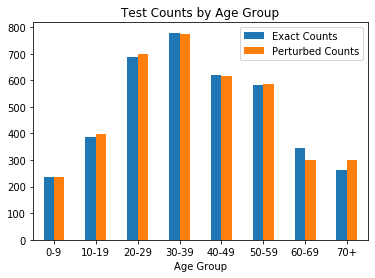

In [13]:
# Extract the set of possible age groups
age_groups = np.sort(data["age_group"].unique())
# Reformat the age group names for nicer display
age_ranges = np.array([a.lstrip("AgeGroup_") for a in age_groups])

# Create a dataframe with both exact and perturbed counts
df = pd.DataFrame(
    {
        "Age Group": age_ranges,
        "Exact Counts": values,
        "Perturbed Counts": perturbed_counts,
    }
)

# Display the two histograms as a table
display(df.style.set_caption("Test Counts by Age Group"))

# Plot the two histograms as bar graphs
df.plot(x="Age Group", title="Test Counts by Age Group", kind="bar", rot=0)
plt.show()

## Integer Counts
In this example, all of the exact counts are integers.  That is because they are the result of so-called counting queries. The perturbed counts produced by the Laplace mechanism are real-valued. In some applications, e.g. when some downstream processing assumes it will receive integer-valued data, we may need the perturbed counts to be integers. One way to achieve this is by simply rounding the outputs of the Laplace mechanism to the nearest integer. Because this differentially private release mechanisms are not affected by this kind of post-processing, doing so will not affect any privacy guarantees.

Alternatively, we could use the geometric mechanism to compute the permuted counts.  The geometric mechanism is simply a discrete version of the Laplace mechanism and it produces integer valued perturbations.

### Basic Usage
As before, to produce such a differentially private histogram using Relm a user would:
   - Read the raw data
   - Compute the exact query responses
   - Create a differentially private release mechanism
   - Compute perturbed query responses

In [14]:
# Create a differentially private release mechanism
from relm.mechanisms import GeometricMechanism
mechanism = GeometricMechanism(epsilon=0.1, sensitivity=1.0)

# Compute perturbed query response
perturbed_counts = mechanism.release(values=values)

### Visualising the Results
As with the Laplace mechanism, we can plot the exact histogram alongside the differentially private histogram to get an idea if we have used too small a value for `epsilon`.

,Age Group,Exact Counts,Perturbed Counts
0,0-9,238,243
1,10-19,386,382
2,20-29,688,683
3,30-39,779,759
4,40-49,621,616
5,50-59,582,592
6,60-69,344,290
7,70+,261,252


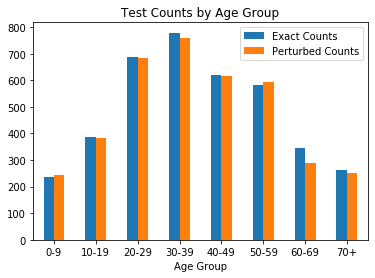

In [15]:
# Extract the set of possible age groups
age_groups = np.sort(data["age_group"].unique())
# Reformat the age group names for nicer display
age_ranges = np.array([a.lstrip("AgeGroup_") for a in age_groups])

# Create a dataframe with both exact and perturbed counts
df = pd.DataFrame(
    {
        "Age Group": age_ranges,
        "Exact Counts": values,
        "Perturbed Counts": perturbed_counts,
    }
)

# Display the two histograms as a table
display(df.style.set_caption("Test Counts by Age Group"))

# Plot the two histograms as bar graphs
df.plot(x="Age Group", title="Test Counts by Age Group", kind="bar", rot=0)
plt.show()

## Sparse Mechanisms
We have three mechanisms that take advantage of sparsity to answer more queries about the data for a given privacy budget. All of these mechanisms compare noisy query responses to a noisy threshold value. If a noisy response does not exceed the noisy threshold, then the mechanism reports only that the value did not exceed the threshold.  Otherwise, the mechanism reports that the value exceeded the threshold. Furthermore, in the latter case some mechanisms release more information about the underlying exact count. This extra information is computed using some other differentially private mechanism and therefore imposes some additional privacy costs.

### Data Wrangling
All three of our mechanims share an input format. We require a sequence of exact query responses and a threshold value to which these responses will be compared.

In [16]:
# Read the raw data
fp = 'examples/20200811_QLD_dummy_dataset_individual_v2.xlsx'
data = pd.read_excel(fp)

# Limit our attention to the onset date column
data.drop(list(data.columns[1:]), axis=1, inplace=True)  

# Remove data with no onset date listed
mask = data['ONSET_DATE'].notna()
data = data[mask]

# Compute the exact query responses
queries = [(pd.Timestamp('2020-01-01')  + i*pd.Timedelta('1d'),) for i in range(366)]
exact_counts = dict.fromkeys(queries, 0)
exact_counts.update(data.value_counts())

dates, values = zip(*sorted(exact_counts.items()))
values = np.array(values, dtype=np.float64)

# Set the threshold value
threshold = 100

### Above Threshold
The simplest of the sparse release mechanisms simply reports the index of the first query response that exceeds the specified threshold.

#### Basic Usage

In [17]:
from relm.mechanisms import AboveThreshold
mechanism = AboveThreshold(epsilon=1.0, sensitivity=1.0, threshold=threshold)
index = mechanism.release(values)

#### Empirical Distribution
Because `AboveThreshold` returns a single index, we can run many experiments and plot a histogram of the results of those experiments to get an empirical estimate of the distribution of the mechanism's output.

In [18]:
TRIALS = 2**10
results = np.zeros(TRIALS)
for i in range(TRIALS):
    mechanism = AboveThreshold(epsilon=1.0, sensitivity=1.0, threshold=threshold)
    index = mechanism.release(values)
    results[i] = index    

#### Visualising the Results

The index of the first exact count that exceeds the threshold is: 105



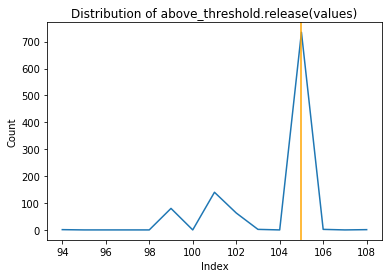

In [20]:
print("The index of the first exact count that exceeds the threshold is: %i\n" % np.argmax(values >= threshold))

histogram = dict.fromkeys(np.arange(min(results), max(results)), 0)
histogram.update(Counter(results))

plt.xlabel("Index")
plt.ylabel("Count")
plt.title("Distribution of above_threshold.release(values)")
plt.plot(list(histogram.keys()), list(histogram.values()))
plt.axvline(x=np.argmax(values >= threshold), color='orange')

### Sparse Indicator
The `SparseIndicator` is a straightforward extension of the `AboveThreshold` mechanism.  Here, we find the indices of several values that exceeds the specified threshold. The number of indices that this mechanism will return is controlled by the `cutoff` parameter.

#### Basic Usage

In [21]:
from relm.mechanisms import SparseIndicator
mechanism = SparseIndicator(epsilon=1.0, sensitivity=1.0, threshold=100, cutoff=3)
indices = mechanism.release(values)

#### Visualise the Results

In [30]:
TRIALS = 16
table = []
for i in range(TRIALS):
    mechanism = SparseIndicator(epsilon=1.0, sensitivity=1.0, threshold=100, cutoff=3)
    indices = mechanism.release(values)
    table.append(indices)
    
print(tabulate(table))

---  ---  ---
103  105  106
101  105  106
101  105  106
102  105  106
105  106  109
 99  101  102
101  102  105
101  104  105
 99  101  102
105  106  108
105  107  108
105  106  107
101  105  106
 93  102  105
101  105  108
101  105  106
---  ---  ---


### Sparse Numeric
The `SparseNumeric` mechanism returns perturbed values alongside the indices of the exact values that exceeded the threshold.

#### Basic Usage

In [22]:
from relm.mechanisms import SparseNumeric
mechanism = SparseNumeric(epsilon=4.0, sensitivity=1.0, threshold=100, cutoff=3)  
indices, perturbed_values = mechanism.release(values)

#### Visualise the Results

In [28]:
TRIALS = 2**4
table = []
for i in range(TRIALS):
    mechanism = SparseNumeric(epsilon=4.0, sensitivity=1.0, threshold=100, cutoff=3)  
    indices, perturbed_values = mechanism.release(values)
    table.append(list(zip(indices, perturbed_values)))

print(tabulate(table))

-------------------------  -------------------------  -------------------------
(105, 115.21839387400541)  (106, 97.59114407023299)   (107, 100.34940313908737)
(105, 117.25417732610367)  (106, 104.23912824635045)  (108, 117.06529281983967)
(105, 115.95392468789942)  (106, 105.70285632926971)  (108, 117.4615241655847)
(105, 118.29109141643858)  (106, 103.15804938206566)  (108, 115.5464560847904)
(105, 117.70329438816407)  (106, 104.40444786503213)  (108, 116.99608848118805)
(101, 94.689048372471)     (105, 116.0949394107738)   (106, 103.06983450354892)
(105, 113.67421829584055)  (106, 101.9473055737617)   (107, 99.95925076899584)
(105, 116.9078528387472)   (106, 105.79938419235987)  (108, 115.9914550249523)
(105, 116.80950692723854)  (106, 102.6301665683568)   (107, 100.67531148143462)
(105, 115.72742036447744)  (106, 107.88994258278399)  (107, 102.52016868776991)
(105, 117.62578285107156)  (106, 103.69083602391765)  (108, 117.29039524923428)
(105, 118.25597266215482)  (108, 116.3736503